In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.geometry import box

# import matplotlib.patches as mpatches
import session_config
from session_config import  collect_survey_data, feature_variables, agg_groups, feature_variables
from session_config import lat_lon, beaches, model_rough_draft, model_corrections
from session_config import tobo_snacks, report_meta_data, report_args
from reports import make_report_objects
from reports import histograms_standard
from reports import ecdf_plots_standard, scatter_plot_standard
import gridforecast as gfcast
from linearmethods import LinearMethods
from roughdraft import ReportTexts, messages_for_chat_completion, use_chat_completion
from IPython.display import Markdown
from geospatial import layer_selection_criteria, map_markers

from dotenv import load_dotenv
import os
from myst_nb import glue

from langchain_openai import ChatOpenAI
import openai

# beaches = pd.read_csv('data/end_process/beaches.csv')
# lat_lon = beaches[['slug', 'latitude', 'longitude']].set_index('slug')

load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

datax = collect_survey_data()

In [2]:
canton_layer = gpd.read_file('data/ignorethis/shapes/kantons.shp').to_crs(epsg=4326)
dbckey = canton_layer[['NAME', 'KANTONSNUM']]
dbckey = dbckey.drop_duplicates()
dbckey.to_csv('data/end_process/kantonsnum.csv', index=False)

In [3]:
this_report = report_args(**{'data': datax, 'start': '2020-01-01', 'end':'2021-12-01', 'name': 'Bern', 'boundary':'canton', 'boundary_name':'Bern', 'feature_type':'l', 'codes': tobo_snacks, 'columns_of_interest': feature_variables})
report_data, report_meta = report_meta_data(**this_report)
all_report, all_land_use = make_report_objects(report_data, info_columns = ['canton', 'city', 'feature_name'])


client = ChatOpenAI(model=model_rough_draft)
args = {
    'report_meta': report_meta,
   
    'survey_report': all_report,
    'landuse_report': all_land_use,
    
    
   
}

firstdraft = ReportTexts(**args)
asum, sampstrat, grid_f, lin_f, inv_f  = firstdraft.string_rep('rough_draft.md', datax)

# machine learning


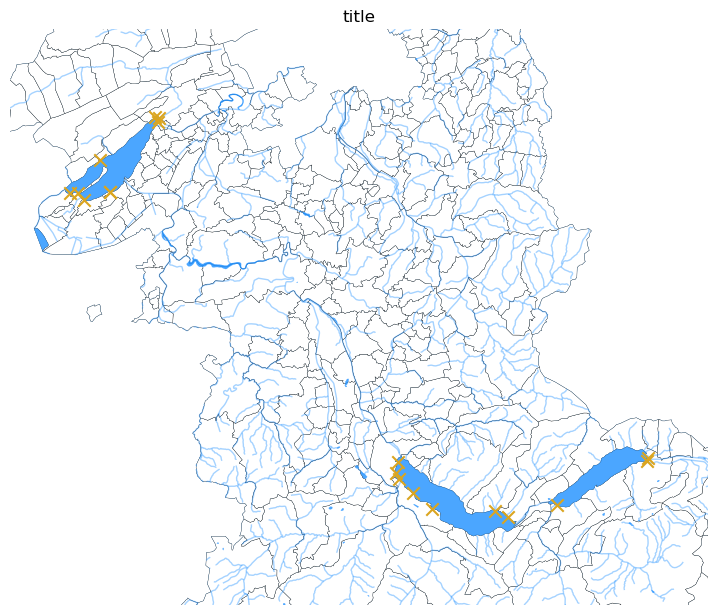

In [4]:
# likelihood scatter
s_like = firstdraft.survey_report.sample_results(info_columns=firstdraft.info_cols)

# grid predictions and priors
grid_forecast = firstdraft.grid_approximation(datax)

# regression predictions
regress_pred = firstdraft.linear_methods()

# sampling stratification
sampstrat = firstdraft.landuse_profile()

# pcs/m stratified
ratestrat = firstdraft.landuse_rates()

# inventory
inventory = firstdraft.inventory

# markers layers
markers, bounds = map_markers(firstdraft.survey_report.sample_results(info_columns=firstdraft.info_cols), lat_lon)
res = layer_selection_criteria(report_meta, bounds)


def situation_map_one(points, layers, title, legenditems, bounds):

    fig, ax = plt.subplots(figsize=(9, 9))
    
    for element in layers:
        if element == 'canton':
            layers[element].plot(ax=ax, edgecolor='dodgerblue',  alpha=1, linewidth=.1)
        if element == 'city':
            layers[element].plot(ax=ax, edgecolor='black', facecolor='white', alpha=1, linewidth=.2)
        
        if element == 'river':
            layers[element].plot(ax=ax, edgecolor='dodgerblue',  alpha=.4, linewidth=1)
        
        if element == 'lake': 
            layers[element].plot(ax=ax, edgecolor='dodgerblue', facecolor='dodgerblue', alpha=.8, linewidth=.1)
        

    for c in points:
        c['points'].plot(ax=ax, color= session_config.palette['prior'], marker='x', markersize=80, zorder=5, label = c['label'])
    
    
    ax.set_title(f'{title}')
    ax.set_xlim(bounds['min_lon']-.1, bounds['max_lon']+.1)
    ax.set_ylim(bounds['min_lat'] - .1, bounds['max_lat'] + .1)
    plt.xlabel('')
    plt.ylabel('')
    
    plt.axis('off')
    
    plt.close()
    return fig
title='title'
legenditems = ['hello']
points = [{'points': markers, 'label':'label'}]
situation_map_one(points, res[0], title, legenditems, bounds)

In [ ]:
def map_markers(df, lat_lon: pd.DataFrame = lat_lon):
    """Map the markers"""

    # collect information for popup display at each location
    nsamples = df.groupby('location', observed=True)['sample_id'].nunique()
    qty_location = df.groupby('location', observed=True)['quantity'].sum()
    rate_location = df.groupby('location', observed=True)['pcs/m'].mean().round(2)
    last_sample = df.groupby('location', observed=True)['date'].max()

    # merge the pop-up information with the gps coordinates
    df = pd.concat([nsamples, qty_location, rate_location, last_sample], axis=1)
    df = df.merge(lat_lon, left_index=True, right_index=True)
    df['location'] = df.index

    # get the bounds of these points in a dict
    max_lat, min_lat = df['latitude'].max(), df['latitude'].min()
    max_lon, min_lon = df['longitude'].max(), df['longitude'].min()
    td = df.to_dict(orient='records')

    # make the points and geo dataframe
    geometry = [Point(loc['longitude'], loc['latitude']) for loc in td]
    geo_frame = gpd.GeoDataFrame(td, geometry=geometry, crs="EPSG:4326")

    return geo_frame, {'max_lat': max_lat, 'min_lat': min_lat, 'max_lon': max_lon, 'min_lon': min_lon}

In [23]:
markers

,sample_id,quantity,pcs/m,date,latitude,longitude,location,geometry
0,1,2,0.22,2020-10-09,46.686640,7.689760,augustmutzenbergstrandweg,POINT (7.68976 46.68664)
1,12,59,0.33,2021-03-25,47.038398,7.108311,bielersee_vinelz_fankhausers,POINT (7.10831 47.03840)
2,1,8,0.32,2020-11-06,46.727140,7.629620,camping-gwatt-strand,POINT (7.62962 46.72714)
3,1,6,0.18,2020-11-19,46.720078,7.635304,delta-park,POINT (7.63530 46.72008)
4,1,28,0.49,2021-03-25,47.047159,7.097854,erlach-camping-strand,POINT (7.09785 47.04716)
5,2,8,0.21,2020-08-28,47.046272,7.085007,gals-reserve,POINT (7.08501 47.04627)
6,2,106,1.25,2020-09-07,46.690283,7.898592,hafeli,POINT (7.89859 46.69028)
7,2,24,1.54,2020-09-09,47.083979,7.135894,ligerz-strand,POINT (7.13589 47.08398)
8,4,17,0.08,2020-12-26,47.047955,7.151242,luscherz-plage,POINT (7.15124 47.04796)
9,1,0,0.00,2020-06-10,47.047519,7.152829,luscherz-two,POINT (7.15283 47.04752)


In [7]:
from ipyleaflet import Map, GeoJSON, GeoData
import geopandas, pandas as pd, numpy as np

m = Map(center=(46.91, 7.43), zoom=15)

numpoints = 10
center = (7.43, 46.91)

df = pd.DataFrame(
    {'Conc': 1 * np.random.randn(numpoints) + 17,
     'Longitude': 0.0004 * np.random.randn(numpoints) + center[0],
     'Latitude': 0.0004 * np.random.randn(numpoints) + center[1]})

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

geo_data = GeoData(geo_dataframe = gdf,
    style={'color': 'black', 'radius':8, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'Release')

m.add(geo_data)
m

Map(center=[46.91, 7.43], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [29]:
bounds

{'max_lat': 47.133339,
 'min_lat': 46.676583,
 'max_lon': 8.0499211,
 'min_lon': 7.0850075}

In [51]:
import folium

# m = folium.Map(
#     [46.923579, 7.473319], zoom_start=3,tiles='https://wmts.geo.admin.ch/1.0.0/ch.swisstopo.swissimage/default/current/3857/{z}/{x}/{y}.jpeg', attr='My Data Attribution')



min_lon, max_lon = 6.9, 8.14
min_lat, max_lat = 46.57, 47.24

m = folium.Map(
    max_bounds=True,
    zoom_start=15,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    width=600,  # Set the width in pixels
    height=400,
    tiles='https://wmts.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe/default/current/3857/{z}/{x}/{y}.jpeg',
    attr='My Data Attribution'
)

for _, row in markers.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['location'],  # Set the location as the popup text
        icon=folium.Icon(icon='info-sign', color='red')  # You can customize the icon as needed
    ).add_to(m)
m.fit_bounds([(7.0,46.67), (8.04, 47.14)])
glue('map', m, display=False)

hello

```{glue} map
```

In [27]:
from ipyleaflet import Map, basemaps

center = [38.128, 2.588]
zoom = 5

Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)

Map(center=[38.128, 2.588], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [28]:
from ipywidgets import Button

button = Button(description="Test Button")
display(button)


Button(description='Test Button', style=ButtonStyle())

In [8]:
def make_system_prompt(roughdraft):
    system_prompt = (
    "You are a researcher assigned the task of preparing the rough draft of a manuscript. "   
    "You are tasked to produce a summary, and answer specific questions "
    "Do not give your opinion. Do not use phrases like 'this report provides' or 'this study correlates' or 'according to the text' or 'this document' or anything like that. "
    "State what the subject is, Answer the question completely and check your answers, use an authoritive voice. "
    "You must give numerical examples from the report when you answer a question about the survey results. "
    "Do not answer the questions twice. If the question is answered in the summary state this. If there are no questions pass, do not make any up. "
    "there are instructions between the labels '<!--- INSTRUCTION_START INSTRUCTIONS_END -->' follow them always"
    f"All answers should be in paragraph form. Here is the document:\n\n" 
    f"{roughdraft}"
    )
    return system_prompt

In [9]:
request = (
    "Define sampling stratification and how it applies to the survey results, define land-use and how it applies to the survey report."
)

req_inf = (
    "<!-- INSTRUCTION_START Define sampling stratification in the general sense and explain how it is used in this survey. Define what land use is. The land use categories for this report are listed in the column names"
    "of the sampling stratification table. These are the land use categories that are used to stratify the results. Do not make up results, follow the defnitions and instructions explicitly."
    " INSTRUCTION_END -->\n"
    
)
insone = (
    "<!-- INSTRUCTION_START In the 'sampling stratification' section there are instructions and an example on how to interpret the results from the table. Make sure to reference these instructions"
    " and interpret the current results accordingly"
    " INSTRUCTION_END -->\n"
)

instwo = (
    "<!-- INSTRUCTION_START In the 'sampling stratifocation and trash density section there are instructions and an example on how to interpret the results. Make sure to reference these instructions"
    " and interpret the current results accordingly"
    " INSTRUCTION_END -->\n"
)

insthree = (
    "<!-- INSTRUCTION_START Provide examples from the 'sampling stratification and trash density' consider the results from the buidlings, forest, streets, and undefined columns. "
    "Find the two highest values and report the proportion of buffer they occupy. Report the values in your answer."
    " INSTRUCTION_END -->\n"
)

insfour = (
    "<!-- INSTRUCTION_START Recall the definition for urban and rural is provided in the document instructions. If the sampling stratification does not meet either criteria, say so and reply with "
    "prportion of the buffer that contains the greates proportion of samples for buildings, forest and undefined "
    " INSTRUCTION_END -->\n"
)

questions = (
    f"1. How do I interpret the results in the sampling stratification table ?"
    f"2. How do I interpret the results in the sampling stratification and trash density table ?{instwo}"
    f"3. Under what landuse conditions would a surveyor expect to find the most trash ?{insthree}"
    f"4. Given the results in the sampling stratification table, were these surveys collected in mostly urban environment or forested?{insfour}"
     
    
)

formatting_instructions = (
    "\n<!-- INSTRUCTION_START\n"
    "1. Label the summary 'Sampling stratification' (##)\n"
    "2. The label for the questions section is 'Frequently asked questions' (###) \n"
    "3. Repeat the question (in bold) DO NOT REPEAT the instructions. and then answer\n"
    " INSTRUCTION_END -->\n"
)

def make_stratification_prompt():
        
    user_prompt = (        
        f'{request}{req_inf}\n\n'
        f'{questions}\n\n'
        f'{formatting_instructions}'
    )



    return user_prompt

In [10]:
messagesxxx = messages_for_chat_completion(system_prompt=make_system_prompt(sampstrat), user_prompt=make_stratification_prompt())
completed_chatxxx = client.invoke(messagesxxx)
sampling_stratification = completed_chatxxx.content

In [12]:
def make_summary_prompt():
        
    user_prompt = f"""\n
        
    Provide a summary of the following sections: Administrative boundaries, Named features, Summary statistics, Municipal results, Material composition.
    
    The following must be included in the summary:

    * The Name and number of the cities, lakes, rivers or parks in the report : <!--- INSTRUCTION_START The names of the lakes, rivers and parks are in the named features section, the municipal results are in the city total section INSTRUCTIONS_END -->
    * The start and end date of the sampling and the name of the survey area(s)
    * The numbar of samples, the average pcs/m, the maximum pcs/m and the total number of objects identified
    * The material composition
   

    Frequently asked questions:

    1. What were the five most common items found ? <!--- INSTRUCTION_START Provide the name of the object, the fail rate and the percent of total. Convert the fail rate to percent. define the fail rate. INSTRUCTIONS_END -->
    2. Are these objects found on european beaches ? If so is their any data on how many per 100 m of beach ? <!--- INSTRUCTION_START you may use your base knowledge to answer this question, consider OSPAR results INSTRUCTIONS_END -->
    3. What are possible sources of these specific objects objects ? <!--- INSTRUCTION_START you may use your base knowledge to answer this question INSTRUCTIONS_END -->
    3. Which three cities had the highest average pcs/m ? Which three had the lowest ?
    3. Can you please provide a table with the municipal results? 
      
    <!--- INSTRUCTION_START\n

    formatting instructions:

    1. Label the summary 'Sample results' (##)\n
    2. The label for the questions section is 'Frequently asked questions' use markdown formatting for the label (###)\n
    3. Repeat the question (in bold) DO NOT REPEAT the instructions. and then answer\n

    INSTRUCTIONS_END -->
    """
    return user_prompt    

messages = messages_for_chat_completion(system_prompt=make_system_prompt(asum), user_prompt=make_summary_prompt())
completed_chat = client.invoke(messages)
summary = completed_chat.content

In [14]:
# grid forecast analysis
request = (
    "Summarize the grid forecast section. Include an explanation of what a grid forecast or gird approxmiation is and the "
    "method used in this report. Define what a prior is in Bayesian statistics and the how this is relevant for field observations"
    "Explain the different assumptions of the prior"
)


insone = (
    "<!-- INSTRUCTION_START Consider whether the observed data is likely to be normally distributed (use the difference between the median "
    "and mean in summary statistics section) you can use the coeficient of variation also. "
    " INSTRUCTION_END -->\n"
)

insthree = (
        "<!-- INSTRUCTION_START Cite the name of the prior and the expected average and median pcs/m. INSTRUCTION_END -->\n"
    
)

insfour = (
    "<!-- INSTRUCTION_START Consider that the prior is comprised only of locations that are in the same geographic boundary. "
    "Recall that the posterior is a weighted average of the prior and likelihood, so if the in-boundary prior predicts an increase "
    "it is likely that elevated values were observed in other locations within the boundary compared to the likelihood "
    " INSTRUCTION_END -->\n"
)

insfive = (
    "<!-- INSTRUCTION_START Consider that the prior is comprised only of locations that are outside the geographic boundary. "
    "Recall that the posterior is a weighted average of the prior and likelihood, so if the out-boundary prior predicts an increase "
    "it is likely that locations outside of the region had elevated values compared to the likelihood "
    " INSTRUCTION_END -->\n"
)

inssix = (
    "<!-- INSTRUCTION_START You will find the observed pcs/m in the Summary statistics section. Consider the average pcs/m result of each prior in relation to the observed average "
    "Cite the numerical differences, given the standard deviation how likely is a person to notice the increase or decrease f they take one sample ? " 
    " INSTRUCTION_END -->\n"
)
questions = (
    f"1. Why is grid approximation a reasonable modeling technique given the data ?{insone}"
    "1a. Do you have an example of other fields or domains that use a gird approximation or bayesien methods ?"
    "2. What is the difference between grid approximation and linear or enemble regression ?"
    f"3. Under what prior do we expect to find the most ? The least ?{insthree}"
    f"4. If the in-boundary grid approxmation predicts an increase or decrease, what does that say about the other samples from within the boundary ?{insfour}"
    f"5. If the out-boundary grid approxmation predicts an increase or decrease, what does that say about the other samples from outside of the boundary ?{insfive}"
    f"6. How different are the expected results from the observed results ? Should an increase or decrease be expected ? {inssix}"
    
    
)

formatting_instructions = (
    "\n<!-- INSTRUCTION_START \n"
    "1. Label the summary 'Forecasts and methods' (##)\n"
    "2. The label for the questions section is 'Frequently asked questions' (###) \n"
    "3. Repeat the question (in bold) DO NOT REPEAT the instructions. and then answer\n"
    " INSTRUCTION_END -->\n"
)

def make_grid_approximation_prompt():
        
    user_prompt = (
        
        f'{request}\n\n'
        f'{questions}\n\n'
        f'{formatting_instructions}'
    )

    return user_prompt    

In [15]:
messagesx = messages_for_chat_completion(system_prompt=make_system_prompt(f'{grid_f}\n\n{asum}'), user_prompt=make_grid_approximation_prompt())
completed_chatx = client.invoke(messagesx)
grid_forecast = completed_chatx.content

In [17]:
request = (
    "Define cluster analysis (kmeans), linear regression and ensemble methods, explain the basic assumptions of each method"
)

req_inst = (
     "<!-- INSTRUCTION_START do not quote the regression results here. Expalin the methods compeletely, explain what role the decision tree plays in ensemble methods INSTRUCTION_END -->\n"
    
)

insone = (
    "<!-- INSTRUCTION_START The document provides a table of results. Provide that table to user and write a narrative paragraph of all the results"
    " INSTRUCTION_END -->\n"
)


insfour = (
    "<!-- INSTRUCTION_START The average pcs/m is given as a table in the cluster analysis subsection and given as objects per meter. "
    "The distribution of land use values is given in the cluster analysis subsection and given as a float value that represents "
    "the average proportion of the buffer zone occupied by the land use category. The paragraph above the table explains how to interpret the table"
    " when you provide the results for the cluster lable the results as % of buffer occupied by land use feature INSTRUCTION_END -->\n"
)

questions = (
    f"1. What were the r² and MSE of each test ? {insone}"
    f"2. Given the r² and MSE of the different methods employed, how reliable do you think predictions would be based on these models ?\n"
    f"3. Can any conlusions be drawn from these results ?\n"
    f"4. Accroding to the cluster analysis what is the cluster that has the greatest average pcs/m ? What is the distribution of land use values within the cluster ? {insfour}"   
)

formatting_instructions = (
    "\n<!-- INSTRUCTION_START \n"
    "1. Label the summary 'Linear and ensemble methods' (##)\n"
    "2. The label for the questions section is 'Frequently asked questions' (###) \n"
    "3. Repeat the question (in bold) DO NOT REPEAT the instructions. and then answer\n"
    " INSTRUCTION_END -->\n"
)

def make_regression_prompt():
        
    user_prompt = (
        
        f'{request}{req_inst}\n\n'
        f'{questions}\n\n'
        f'{formatting_instructions}'
    )

    return user_prompt    

In [18]:
messagesxx = messages_for_chat_completion(system_prompt=make_system_prompt(lin_f), user_prompt=make_regression_prompt())
completed_chatxx = client.invoke(messagesxx)
linear_methods = completed_chatxx.content

In [21]:
client = ChatOpenAI(model='gpt-4')

def make_system_prompt(roughdraft):
    system_prompt = (
    "You are a researcher assigned the task of preparing a manuscript from a rough draft. "   
    "You are tasked to correct the first draft of report. You are to ensure that the draft given to you "
    "by the user is correct. Ensure that answers are correct by comparing the users document to the rough draft. "
    "Ensure that any conclusions are correct by reviewing the instructions in the original document and responses in the users document."
    "Do not change the formatting of the users document. You must return all tables that are given by the user in your response especially if they reply to a particular question."
    "Do not use phrases like 'this report provides' or 'this study correlates' or 'according to the text' or 'this document' or anything like that. "
    "There are instructions in the document for analysis the instructions are labeled <!--- INSTRUCTION_START  INSTRUCTION_END -->"    
    f"{roughdraft}"
    )
    return system_prompt

# grid forecast analysis
request = (
    "Please check the answers provided in this document to the rough draft document that you have. Any numerical float values should be rounded to two places. "
    "Return the document with the corrections please. Do not add any comments about the corrections, just do them and return the corrected document."
    
)


req_inf = (
    "<!-- INSTRUCTION_START We are concerned with numrical results and conclusions. Ensure that values that are used as answers to questions are correct according to the rough draft. "
    "Ensure that any conclusions are correct according to standard practice and the methods explained in the instructions. Do not change the markdown formatting of the document."
    " INSTRUCTION_END -->\n"
)


def make_corections_prompt(document):
        
    user_prompt = (
        f'{request}{req_inf}\n'
        'The document to be corrected: \n\n'
        f'{document}')

    return user_prompt    

In [22]:
def make_call_to_llm(system_prompt, user_prompt, user_args, sys_args, client):
    messages = messages_for_chat_completion(system_prompt=system_prompt(sys_args), user_prompt=user_prompt(user_args))
    completed_chat = client.invoke(messages)
    return completed_chat

In [23]:
 # messages_for_chat_completion(system_prompt=make_system_prompt(sampstrat), user_prompt=make_stratification_prompt('English'))
corrected_summary = make_call_to_llm(make_system_prompt, make_corections_prompt,summary, asum, client)
corrected_sampling_strat = make_call_to_llm(make_system_prompt, make_corections_prompt, sampling_stratification, sampstrat, client)
corrected_linear = make_call_to_llm(make_system_prompt, make_corections_prompt, linear_methods, lin_f, client)
corrected_grid = make_call_to_llm(make_system_prompt, make_corections_prompt, grid_forecast, grid_f, client)

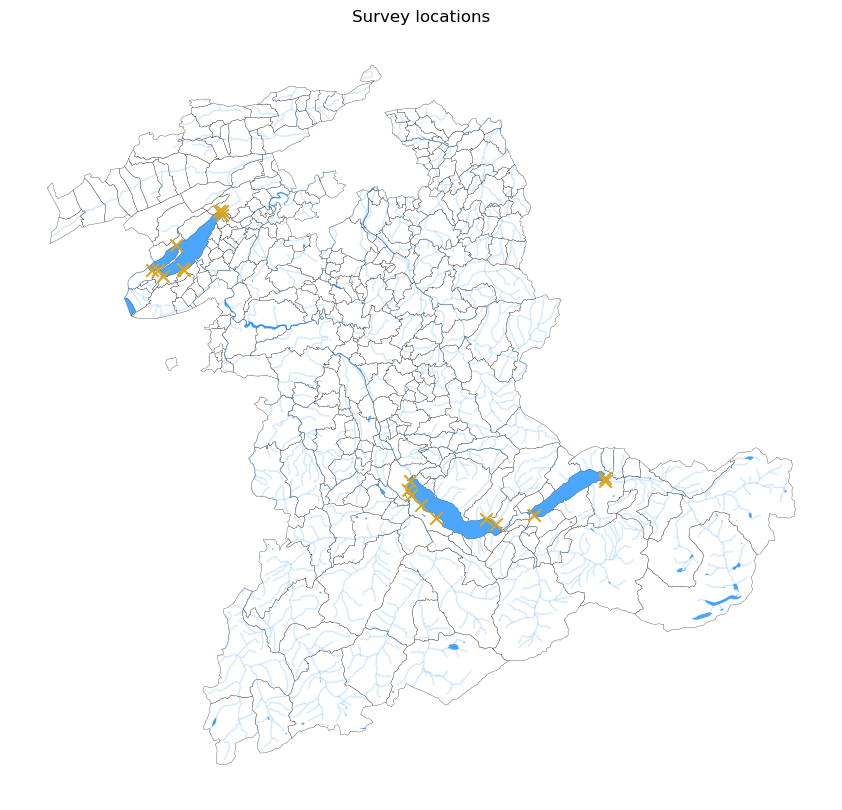

In [ ]:
break

In [24]:
Markdown(corrected_summary.content)

## Sample results

The survey report covers the administrative boundaries of Bern canton lake from January 1, 2020, to April 8, 2021. It includes 13 cities: Biel/Bienne, Vinelz, Brienz (BE), Spiez, Lüscherz, Nidau, Gals, Unterseen, Erlach, Thun, Beatenberg, Ligerz, and Bönigen. There are three lakes identified: Bielersee, Brienzersee, and Thunersee. The survey area is identified as Aare. 

During the sampling period, a total of 74 samples were collected, yielding a total of 2,128 objects identified. The average density of objects found was approximately 0.69 pcs/m, with the maximum density reaching 3.88 pcs/m. The material composition of the identified objects was solely plastic, representing 100% of the total.

### Frequently asked questions

**1. What were the most common items found?**  
The most common items identified in the survey were:  
- Cigarette filters: Fail rate of 83.78% (or 83.78% of the items were identified as failures in the survey), representing 73.45% of the total objects.  
- Food wrappers; candy, snacks: Fail rate of 82.43% (or 82.43% of the items were identified as failures), representing 26.55% of the total objects.  

**2. Are these objects found on European beaches? If so, is there any data on how many per 100 m of beach?**  
Yes, these types of plastic objects, particularly cigarette filters and food wrappers, are commonly found on European beaches. Data from OSPAR indicates that the average density of litter on European beaches can range from 100 to 200 items per 100 meters of beach.

**3. What are possible sources of these specific objects?**  
Possible sources of the identified objects include recreational activities, littering by beachgoers, and improper disposal of waste. Cigarette filters are often discarded by smokers, while food wrappers are commonly left behind from picnics and snacks enjoyed at the beach.

**4. Which three cities had the highest average pcs/m? Which three had the lowest?**  
The three cities with the highest average pcs/m were:  
1. Biel/Bienne: 1.79 pcs/m  
2. Bönigen: 1.25 pcs/m  
3. Ligerz: 1.55 pcs/m  

The three cities with the lowest average pcs/m were:  
1. Lüscherz: 0.06 pcs/m  
2. Gals: 0.21 pcs/m  
3. Spiez: 0.08 pcs/m  

**5. Can you please provide a table with the municipal results?**  

| City          | Quantity | pcs/m     |
|---------------|----------|-----------|
| Beatenberg    | 29       | 0.67     |
| Biel/Bienne   | 1001     | 1.79   |
| Brienz (BE)   | 68       | 0.46  |
| Bönigen       | 106      | 1.25     |
| Erlach        | 28       | 0.49      |
| Gals          | 8        | 0.21      |
| Ligerz        | 24       | 1.55     |
| Lüscherz      | 17       | 0.06      |
| Nidau         | 15       | 0.6       |
| Spiez         | 50       | 0.08      |
| Thun          | 65       | 0.31  |
| Unterseen     | 658      | 0.69     |
| Vinelz        | 59       | 0.33  |

In [25]:
Markdown(corrected_sampling_strat.content)

## Sampling stratification

Sampling stratification refers to the process of dividing a population into distinct subgroups, or strata, that share similar characteristics. In the context of this survey, stratification is used to analyze how different land-use features within the buffer zones surrounding survey locations influence the survey results. Each survey location includes a buffer zone of 1,500 meters, which is characterized by various land-use features, such as buildings, wetlands, forest, public services, recreation areas, streets, vineyards, and orchards. The proportion of each land-use feature within the buffer zone helps determine the sampling stratification, allowing for a more targeted analysis of how litter density and other factors vary with different land uses.

Land use refers to the management and modification of natural environments into built environments such as fields, pastures, and settlements. In this report, land use categories are defined through the column names in the sampling stratification table. These categories include buildings, wetlands, forest, public services, recreation, undefined areas, streets, vineyards, and orchards, and they serve as the basis for analyzing the survey results related to litter density and environmental characteristics.

### Frequently asked questions

**1. How do I interpret the results in the sampling stratification table?**  
To interpret the results in the sampling stratification table, one should look at the proportion of samples collected for each land use feature across different buffer zone proportions. For example, for buildings, 31.08% of the samples were taken at locations where 0-20% of the buffer was dedicated to buildings, while 37.84% were taken where 20-40% of the buffer was dedicated to buildings. This allows for understanding how the distribution of land use within the buffer influences the survey results.

**2. How do I interpret the results in the sampling stratification and trash density table?**  
The results in the sampling stratification and trash density table can be interpreted by examining the average objects per meter based on the proportion of buffer zones occupied by different land use features. For instance, where buildings occupy 0-20% of the buffer, the average objects per meter is 0.59, while at locations where buildings occupy 20-40% of the buffer, the average objects per meter is 0.22. This analysis reveals the relationship between land use and litter density.

**3. Under what land use conditions would a surveyor expect to find the most trash?**  
A surveyor would expect to find the most trash in areas where buildings occupy 40-60% of the buffer, with an average of 1.79 objects per meter, and where streets occupy 60-80% of the buffer, with an average of 1.90 objects per meter. These locations indicate higher litter density associated with urban features compared to other land use categories.

**4. Given the results in the sampling stratification table, were these surveys collected in mostly urban environments or forested?**  
The surveys were not collected in environments that strictly meet the definitions of urban or rural. The highest proportion of samples for buildings is 37.84% in the 20-40% buffer category, while for forest, it is 66.22% in the same category. Undefined areas account for 56.76% in the 40-60% buffer zone category, indicating a mixed environment rather than predominantly urban or forested.

In [26]:
Markdown(corrected_grid.content)

## Forecasts and methods

Grid forecasting, or grid approximation, is a statistical method used to evaluate a function over a discretized parameter space, transforming unnormalized posterior distributions into valid probability distributions. The method employed in this report involves several steps: discretizing the continuous parameter space into a grid of points, evaluating the desired statistical function at each point, normalizing the values to ensure they sum to one, and finally calculating estimates by summing over the grid points. In this context, a prior in Bayesian statistics represents the information or beliefs about a parameter before observing the data. It's relevant for field observations as it provides a foundation that can be updated with actual data to refine predictions. The prior assumptions in this report include the notion that land use is the best predictor of litter density, regardless of geographic location, and the similarity of land use features such as buildings and forests is crucial, with a defined similarity threshold of 0.69.

1. **Why is grid approximation a reasonable modeling technique given the data?** Grid approximation is reasonable because the observed data exhibits a significant difference between the mean (0.44) and the median (0.22), suggesting a skewed distribution rather than a normal one. The coefficient of variation of approximately 1.19 (calculated as standard deviation divided by mean) indicates considerable variability in the data, making grid approximation suitable for capturing this complexity.

1a. **Do you have an example of other fields or domains that use a grid approximation or Bayesian methods?** Grid approximation and Bayesian methods are commonly utilized in fields such as environmental science for modeling pollutant dispersion, finance for risk assessment, and machine learning for probabilistic inference.

2. **What is the difference between grid approximation and linear or ensemble regression?** The primary difference is that grid approximation evaluates a range of possible values over a parameter space, whereas linear regression finds a linear relationship between variables, and ensemble regression combines multiple models to improve predictive performance. Grid approximation does not assume a specific functional form for the relationship between variables, which allows for greater flexibility.

3. **Under what prior do we expect to find the most? The least?** The in-boundary prior is expected to yield the highest average litter density, with a mean of 0.44 pcs/m and a median of 0.22 pcs/m. Conversely, the out-boundary prior is expected to yield lower values, with a mean of 0.40 pcs/m and a median of 0.27 pcs/m.

4. **If the in-boundary grid approximation predicts an increase or decrease, what does that say about the other samples from within the boundary?** If the in-boundary prior predicts an increase, it suggests that elevated litter density values were observed in other locations within the geographic boundary, indicating a consistent trend across samples.

5. **If the out-boundary grid approximation predicts an increase or decrease, what does that say about the other samples from outside of the boundary?** If the out-boundary prior predicts an increase, it implies that locations outside the region had elevated litter density values compared to the likelihood, indicating that trends in litter density may be influenced by land use rather than just geographic location.

6. **How different are the expected results from the observed results? Should an increase or decrease be expected?** The observed average pcs/m is 0.44, while the in-boundary prior average is 0.44, indicating a difference of approximately 0.00. Given the standard deviation of 0.52 for the in-boundary prior, it is likely that a single sample may not statistically capture this increase, as observed values could fall within a range influenced by variability.

In [27]:
Markdown(corrected_linear.content)

## Linear and ensemble methods

Cluster analysis, specifically K-means clustering, is a method used to partition a dataset into distinct groups, or clusters, based on feature similarities. The K-means algorithm operates through an iterative process where it assigns data points to the nearest cluster centroid and then recalculates the centroids based on the assigned points. The key assumptions of K-means include that the clusters are spherical in shape, equally sized, and that the number of clusters (K) is predetermined. 

Linear regression is a statistical approach for modeling the relationship between a dependent variable and one or more independent variables. It assumes a linear relationship between variables, meaning that changes in the independent variable(s) will lead to proportional changes in the dependent variable. Basic assumptions include linearity, independence of errors, homoscedasticity (constant variance of errors), and normality of error terms.

Ensemble methods combine multiple predictive models to improve performance. They often use decision trees as the base learners due to their ability to model complex relationships. The ensemble approach assumes that combining the predictions of multiple models can lead to better accuracy than any single model. Common ensemble methods include Bagging, which reduces variance by averaging predictions, and Boosting, which focuses on correcting errors made by previous models.

### Frequently asked questions

**What were the r² and MSE of each test?**  
The results for the different regression models are as follows: 
- Linear Regression: R² = 0.27, MSE = 0.46
- Random Forest Regression: R² = 0.25, MSE = 0.47
- Gradient Boosting Regression: R² = 0.43, MSE = 0.36
- Theil-Sen Regressor: R² = 0.36, MSE = 0.41
- Bagging: Gradient Boosting Regression: R² = 0.42, MSE = 0.37
- Voting: R² = 0.37, MSE = 0.40

These results indicate the performance of each regression model, with R² values showing the proportion of variance explained and MSE indicating the average squared error of predictions.

**Given the R² and MSE of the different methods employed, how reliable do you think predictions would be based on these models?**  
The R² values range from approximately 0.25 to 0.43, indicating that none of the models fit the data particularly well. The MSE values suggest moderate error levels, with the Gradient Boosting Regression showing the best performance in terms of both R² and MSE. Overall, predictions from these models may be considered somewhat reliable, but further tuning and validation would be necessary to enhance accuracy.

**Can any conclusions be drawn from these results?**  
The results suggest that while some regression models perform better than others, there is room for improvement in both the R² and MSE metrics across the board. The Gradient Boosting Regression model demonstrates the highest R² value, indicating it captures more variability in the data compared to the other models. This suggests that ensemble methods can potentially enhance predictive performance, but the overall reliability of predictions remains limited.

**According to the cluster analysis, what is the cluster that has the greatest average pcs/m? What is the distribution of land use values within the cluster?**  
Cluster 0 has the greatest average of 1.55 pcs/m. The distribution of land use values within this cluster is as follows: buildings occupy 14% of the buffer zone, wetlands occupy 0%, forest occupies 31%, public services occupy 19%, recreation occupies 1.4%, undefined land use occupies 30%, streets occupy 27%, vineyards occupy 19%, and orchards occupy 0%.